##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.1.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

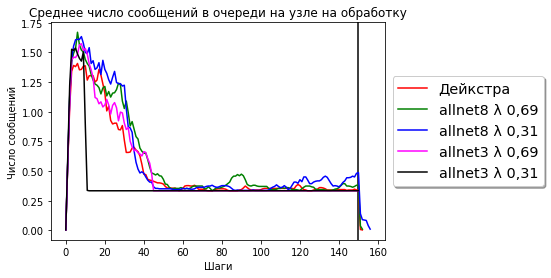

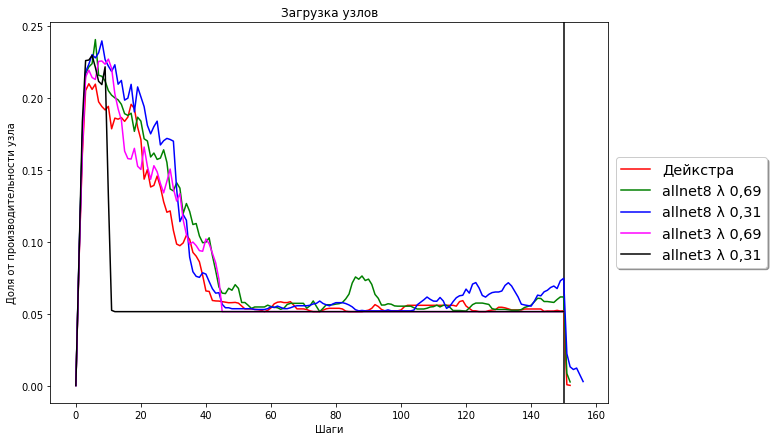

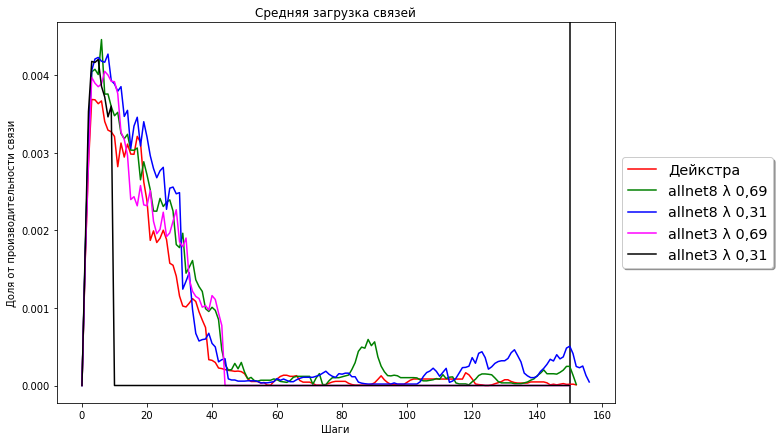

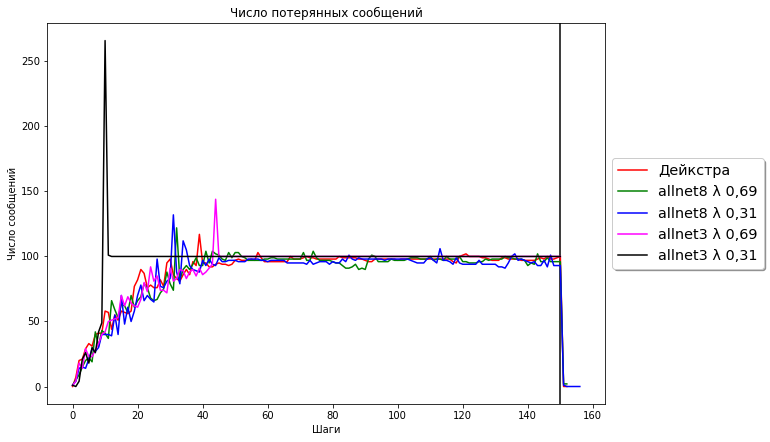

Доставлено 1589 Потеряно 89.4074% -Дейкстра
Доставлено 1763 Потеряно 88.2475% -allnet8 λ 0,69
Доставлено 1915 Потеряно 87.2342% -allnet8 λ 0,31
Доставлено 1480 Потеряно 90.1340% -allnet3 λ 0,69
Доставлено 517 Потеряно 96.5536% -allnet3 λ 0,31


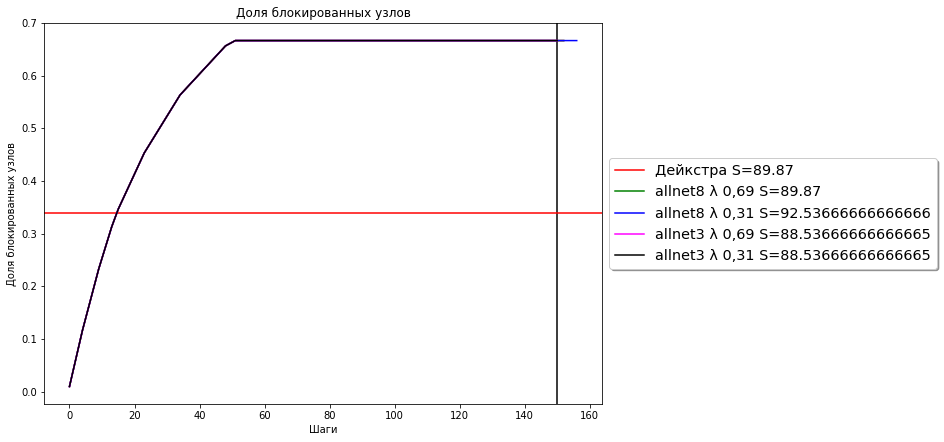

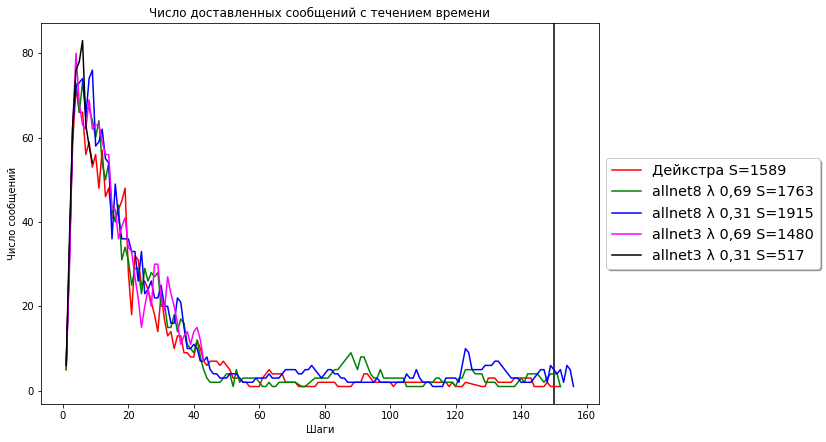

In [3]:
log_tags = [
 {"tag":  "456380cc-5d85-4345-8f3c-1c0f7c2c70dd", "label": "Дейкстра", "color": "red"},

 {"tag":  "cb556536-9d84-4720-904a-569f403c52d1", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "133f9ac6-15ae-42a5-be15-ebe246805d32", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "28c333a5-8465-4f67-8a3d-4bbd4b29527e", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "ceeb73d8-6c06-4792-842d-db6cb3a950be", "label": "allnet3 λ 0,31", "color": "black"},

    #  magenta red green black
 
]     
quantity = 100;

showStat()
showStatBlocked();  
showStatMessage(); 


<strong>Quantity 500 </strong>

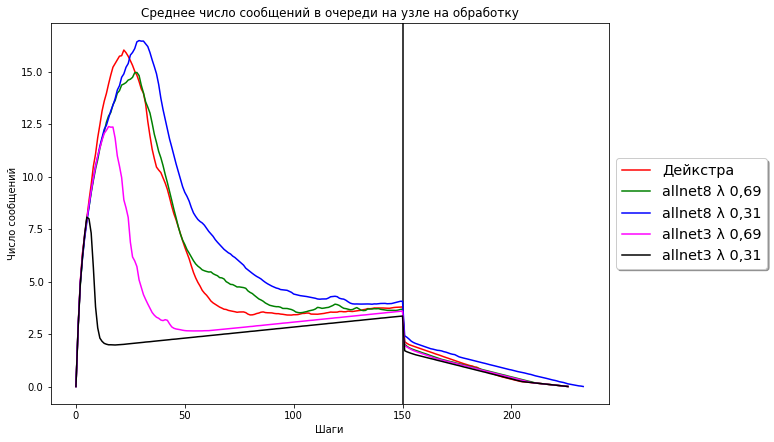

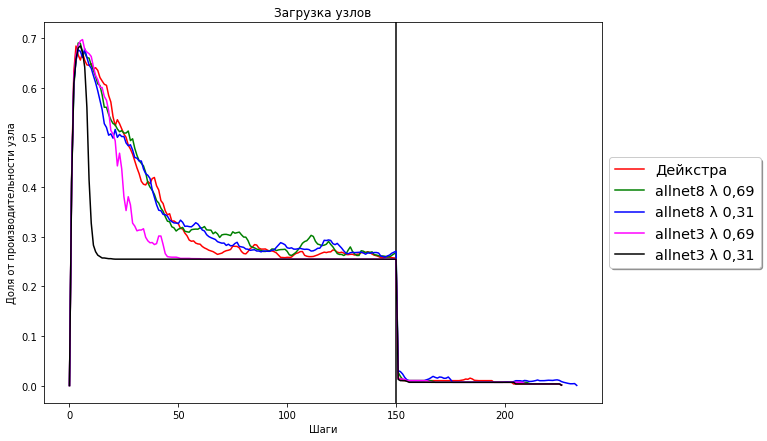

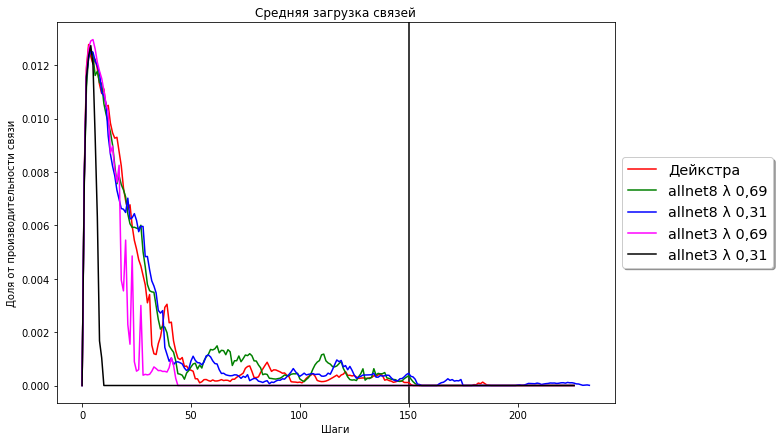

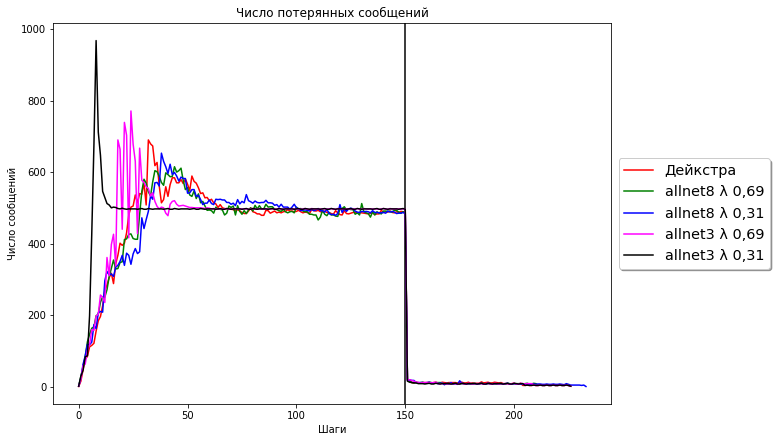

Доставлено 3844 Потеряно 94.8747% -Дейкстра
Доставлено 4379 Потеряно 94.1614% -allnet8 λ 0,69
Доставлено 4276 Потеряно 94.2987% -allnet8 λ 0,31
Доставлено 2826 Потеряно 96.2321% -allnet3 λ 0,69
Доставлено 937 Потеряно 98.7507% -allnet3 λ 0,31


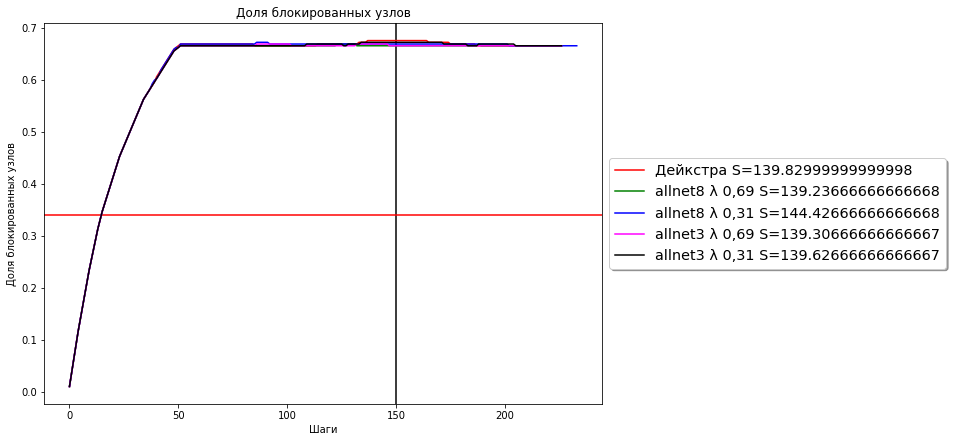

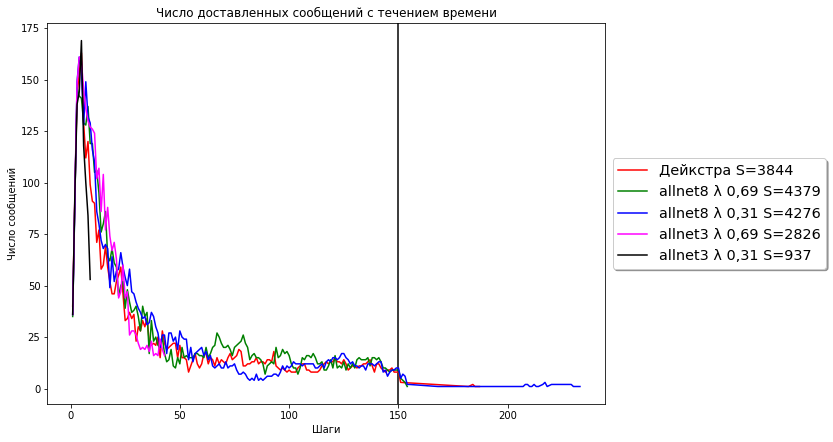

In [4]:
log_tags = [
 {"tag":  "e66bda49-9502-4f5c-a9bc-88ee5dda4cef", "label": "Дейкстра", "color": "red"},

 {"tag":  "168be074-8d63-4d61-9ff8-dbf28b47f128", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "3c9d53aa-51fe-4ff5-a92f-ef8073c5ae42", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "bd22830e-4b9f-4068-a8c9-36112565c95b", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "53450940-d21a-44c7-ad2a-851fdcd0a29a", "label": "allnet3 λ 0,31", "color": "black"},

]
quantity = 500;  
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

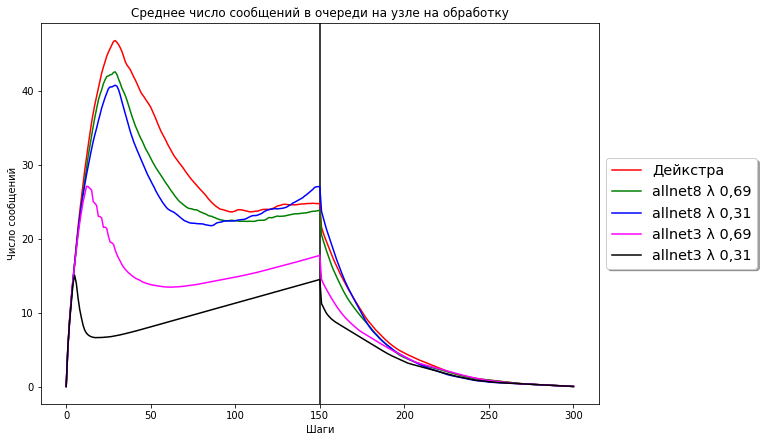

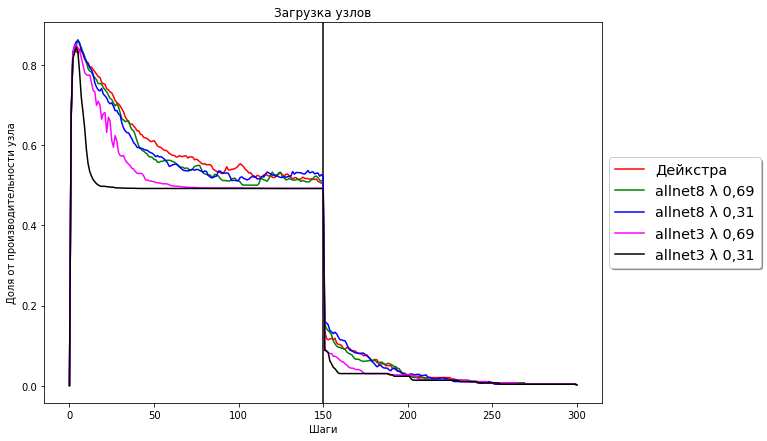

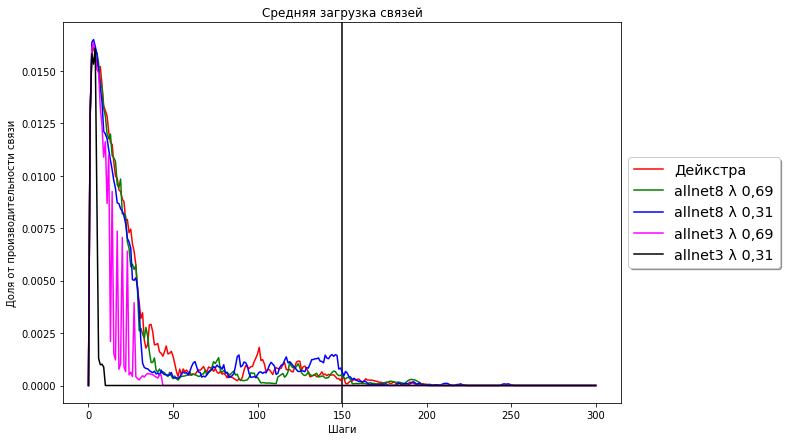

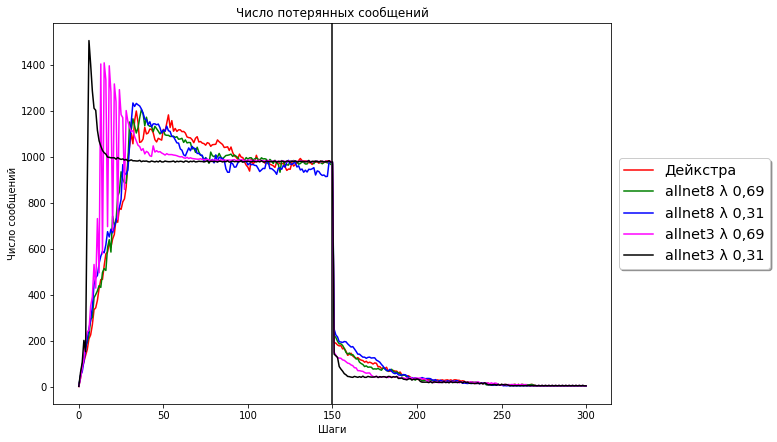

Доставлено 4306 Потеряно 97.1294% -Дейкстра
Доставлено 4474 Потеряно 97.0174% -allnet8 λ 0,69
Доставлено 4537 Потеряно 96.9754% -allnet8 λ 0,31
Доставлено 2154 Потеряно 98.5640% -allnet3 λ 0,69
Доставлено 704 Потеряно 99.5307% -allnet3 λ 0,31


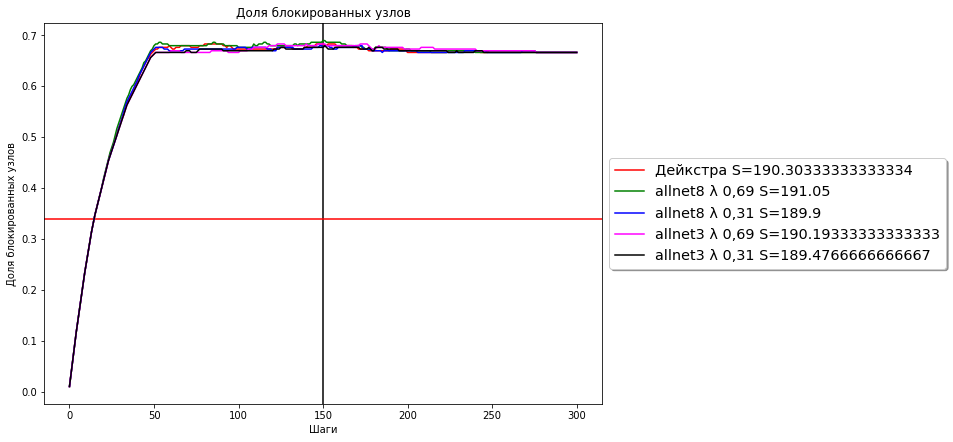

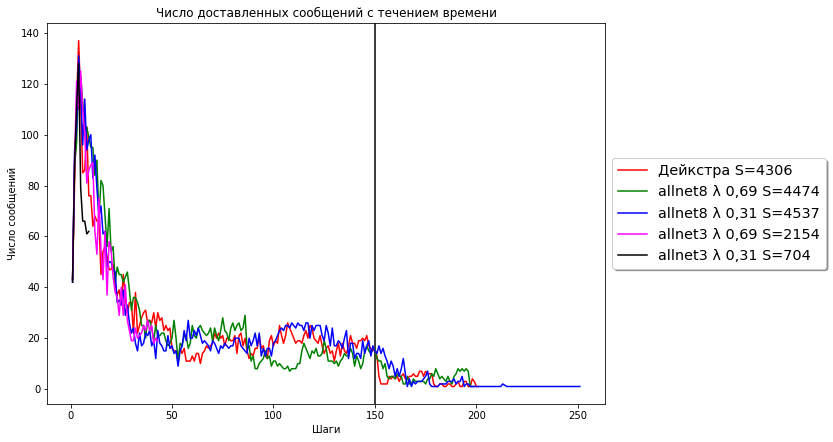

In [5]:
log_tags = [
 {"tag":  "6c5d04e2-0ae3-44ad-aec9-2325aecd114f", "label": "Дейкстра", "color": "red"},

 {"tag":  "5c150532-7a96-4f84-915c-067812b29af4", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "34c31d0c-c75e-4867-9528-68e886ca1adf", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "cf333573-ad81-4eb8-9269-eb715935428b", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "5d4ad3e3-016d-4174-8ac2-fb808a6948b4", "label": "allnet3 λ 0,31", "color": "black"},

]
quantity = 1000;  
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

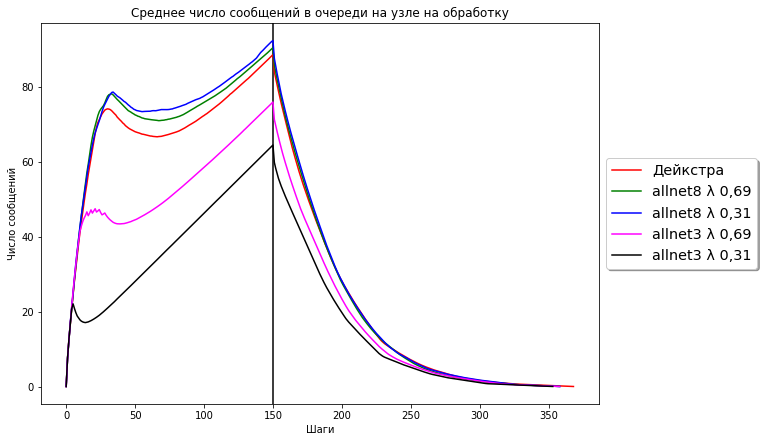

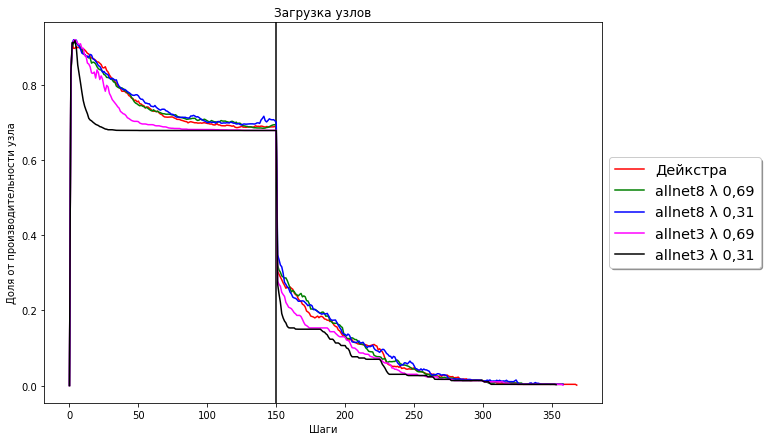

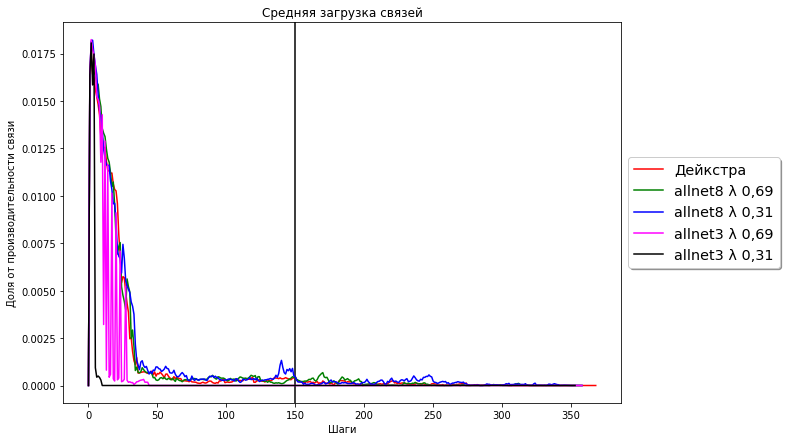

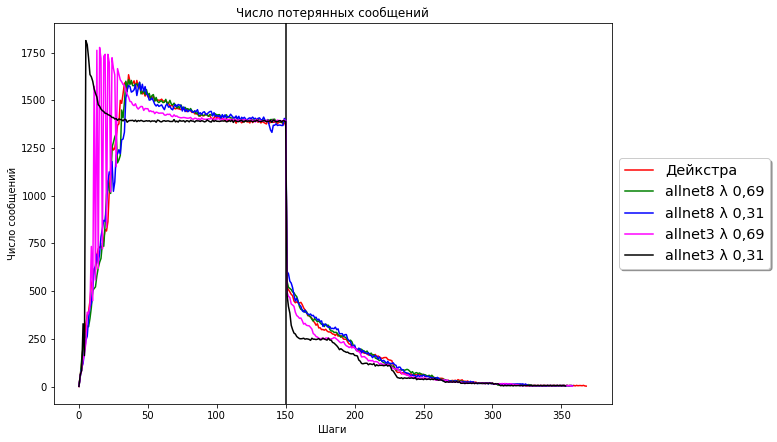

Доставлено 3796 Потеряно 98.3129% -Дейкстра
Доставлено 4009 Потеряно 98.2182% -allnet8 λ 0,69
Доставлено 4598 Потеряно 97.9565% -allnet8 λ 0,31
Доставлено 1573 Потеряно 99.3009% -allnet3 λ 0,69
Доставлено 447 Потеряно 99.8013% -allnet3 λ 0,31


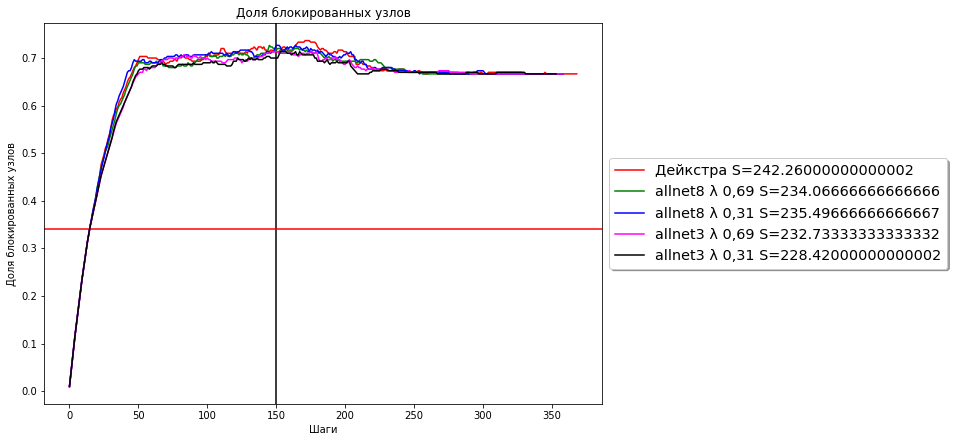

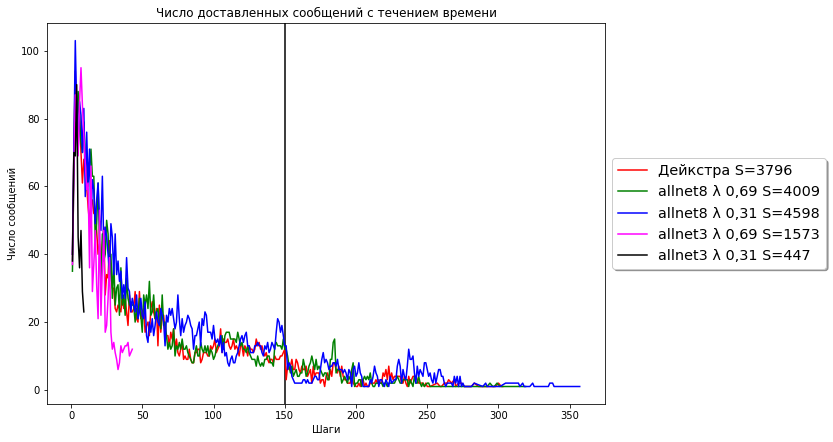

In [6]:
log_tags = [
 {"tag":  "e0815273-7173-4afd-b579-c9b98d2f6f86", "label": "Дейкстра", "color": "red"},

 {"tag":  "3594023d-655f-4768-ae35-5fe59e6841f6", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "a587e50d-e86c-4190-a549-51406f4b91f3", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "82ab3e02-2b47-4069-a0ec-72876ceba1d5", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "fce5adda-633d-48f4-9811-4809585905e4", "label": "allnet3 λ 0,31", "color": "black"},

]
quantity = 1500;  
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 3480 Потеряно 92.2668% -Дейкстра
Доставлено 4336 Потеряно 90.3647% -allnet8 λ 0,69
Доставлено 3718 Потеряно 91.7380% -allnet8 λ 0,31
Доставлено 2489 Потеряно 94.4690% -allnet3 λ 0,69
Доставлено 970 Потеряно 97.8445% -allnet3 λ 0,31


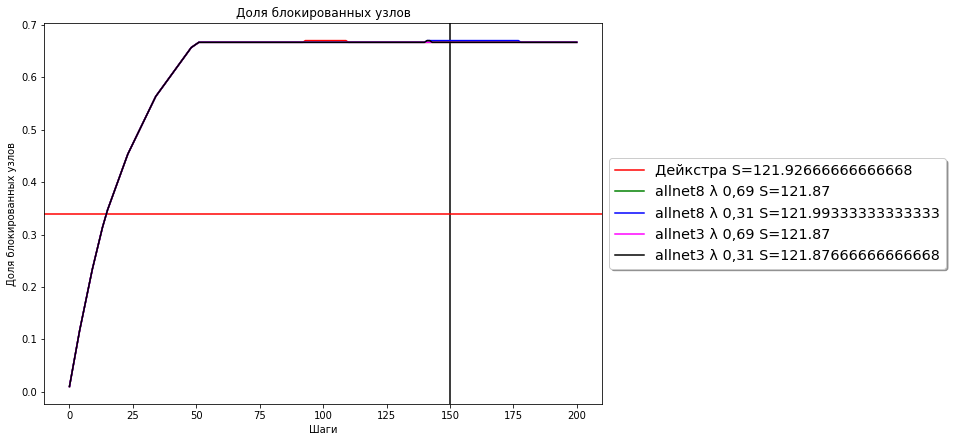

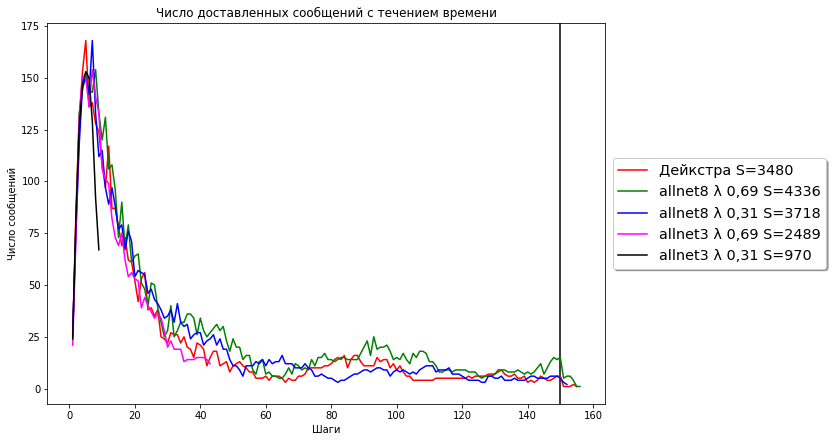

Доставлено 4737 Потеряно 95.4886% -Дейкстра
Доставлено 5214 Потеряно 95.0343% -allnet8 λ 0,69
Доставлено 4265 Потеряно 95.9381% -allnet8 λ 0,31
Доставлено 2589 Потеряно 97.5343% -allnet3 λ 0,69
Доставлено 727 Потеряно 99.3076% -allnet3 λ 0,31


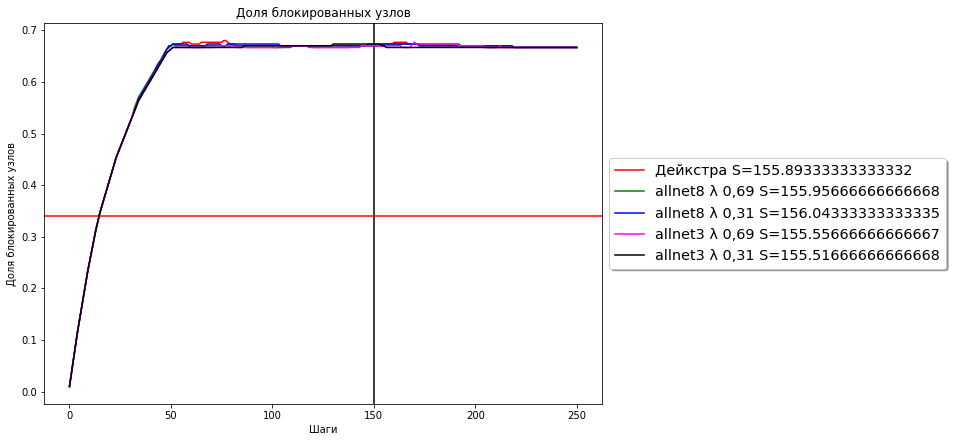

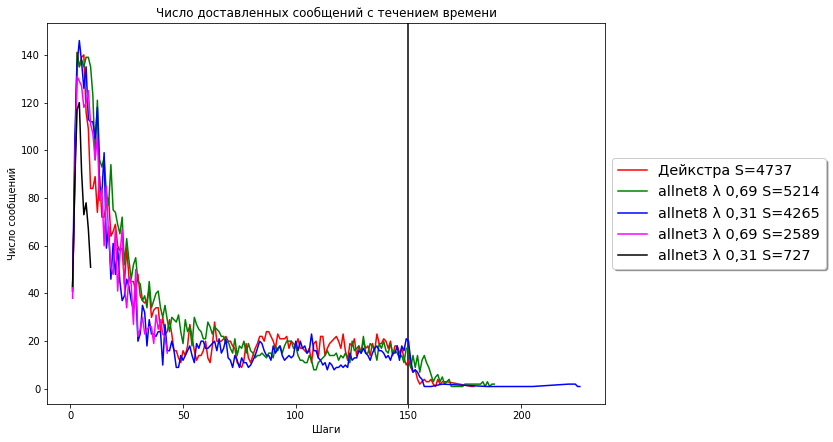

Доставлено 3990 Потеряно 97.0445% -Дейкстра
Доставлено 4901 Потеряно 96.3697% -allnet8 λ 0,69
Доставлено 4931 Потеряно 96.3474% -allnet8 λ 0,31
Доставлено 2285 Потеряно 98.3074% -allnet3 λ 0,69
Доставлено 700 Потеряно 99.4815% -allnet3 λ 0,31


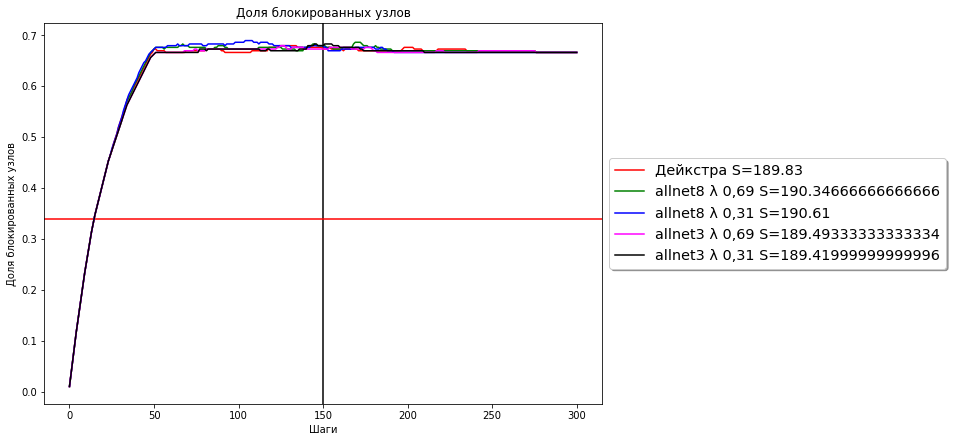

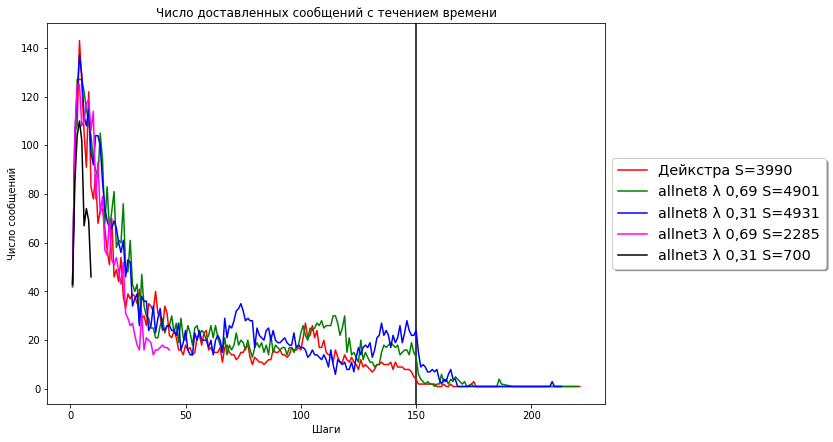

Доставлено 4288 Потеряно 97.8010% -Дейкстра
Доставлено 4911 Потеряно 97.4816% -allnet8 λ 0,69
Доставлено 4495 Потеряно 97.6949% -allnet8 λ 0,31
Доставлено 1639 Потеряно 99.1595% -allnet3 λ 0,69
Доставлено 531 Потеряно 99.7277% -allnet3 λ 0,31


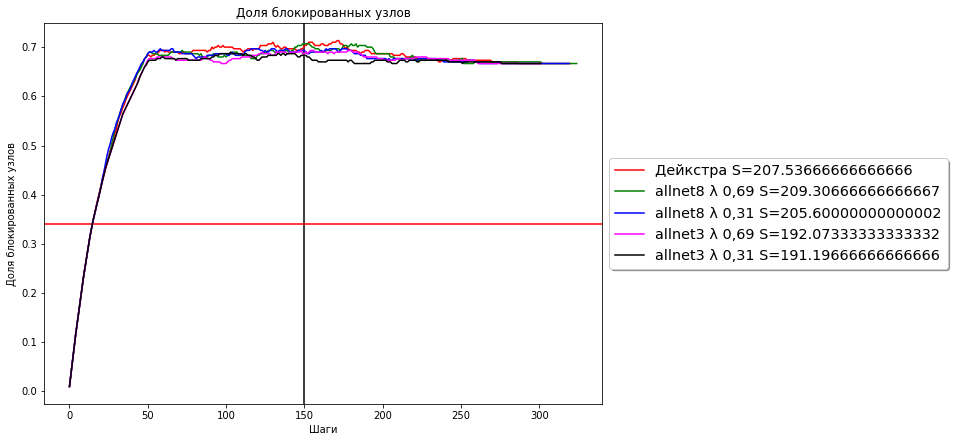

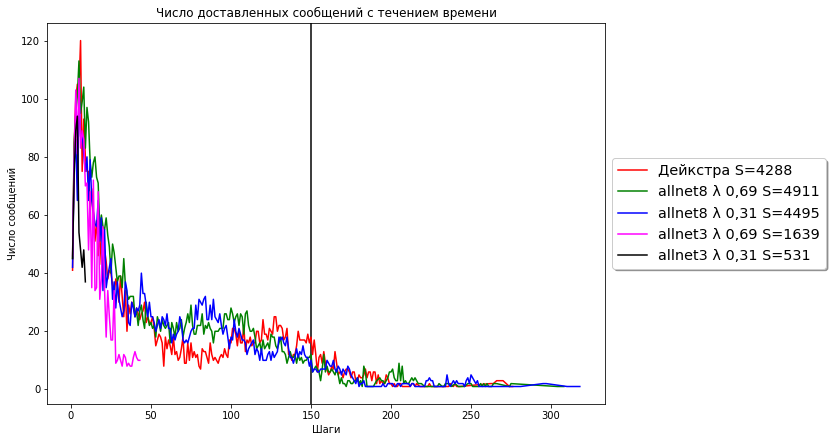

In [7]:
quantity = 300;  
log_tags = [
 {"tag":  "cce11ded-574f-45d5-a453-e90c57fae874", "label": "Дейкстра", "color": "red"},

 {"tag":  "4658c993-e145-4ad8-9a45-ba68954c2dde", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "7ba1bdee-e8aa-43dd-8725-0043943b4669", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "28e504e4-694b-4ac5-90f5-7e9d1b48934b", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "8271de56-58b4-45d9-85f1-28132b7be648", "label": "allnet3 λ 0,31", "color": "black"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
  {"tag":  "f0f139fc-d40d-4fe8-90b0-dd5f84c7a545", "label": "Дейкстра", "color": "red"},

 {"tag":  "6eba4b8c-6e6e-4296-80bb-bf88fa443350", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "b8d04f30-2140-41c4-b2e4-805371f8c1c3", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "e45dcea5-26d6-487a-aabd-8bdd2bb5673f", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "463c606f-02f7-49de-b76c-1242b99fde3d", "label": "allnet3 λ 0,31", "color": "black"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
  {"tag":  "4cd746cb-b2ae-46ad-ad64-d275bf240711", "label": "Дейкстра", "color": "red"},

 {"tag":  "901e0a19-cb70-49a7-8ea5-749e9555bcf0", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "827b69b6-712c-4f68-9812-cc6dbe9ed1d8", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "0cd71d5c-ac65-41b9-9aa5-ad03f534554b", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "cfad471b-b037-4f46-94d8-b140891609eb", "label": "allnet3 λ 0,31", "color": "black"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
  {"tag":  "eb9233fb-93a1-4dd7-9e23-bb76c929f841", "label": "Дейкстра", "color": "red"},

 {"tag":  "8d8082c1-3012-4d74-abd4-2f25f7daadca", "label": "allnet8 λ 0,69", "color": "green"},
 {"tag":  "af2dba96-c754-482f-bded-ed21dfe5b917", "label": "allnet8 λ 0,31", "color": "blue"},
    
 {"tag":  "837e8f4d-a3c1-43ce-bf1e-f0b3cb85d877", "label": "allnet3 λ 0,69", "color": "magenta"},
 {"tag":  "27586334-bb24-4240-8c2d-cec289829b52", "label": "allnet3 λ 0,31", "color": "black"},
]
showStatBlocked();  
showStatMessage();

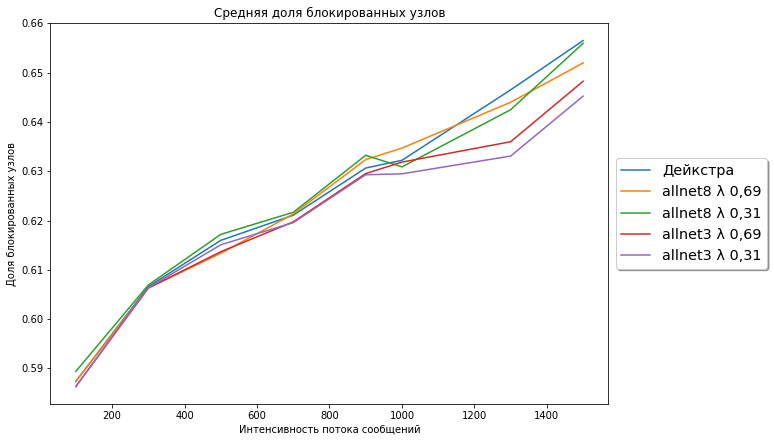

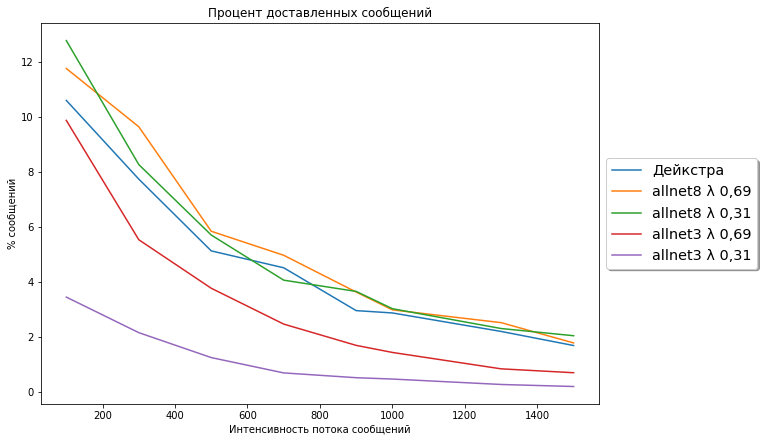

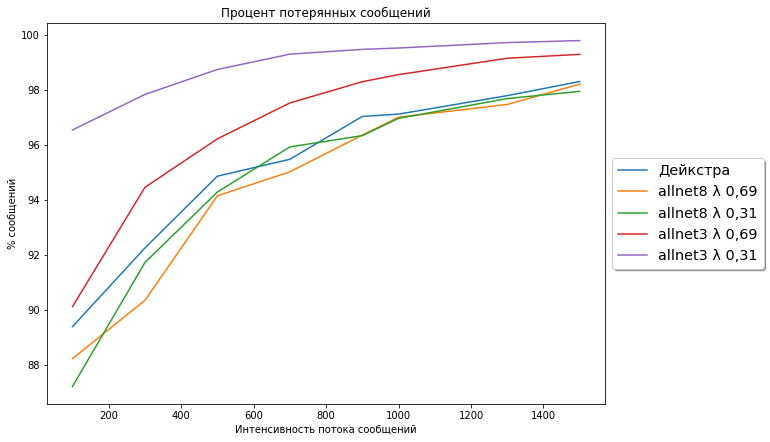

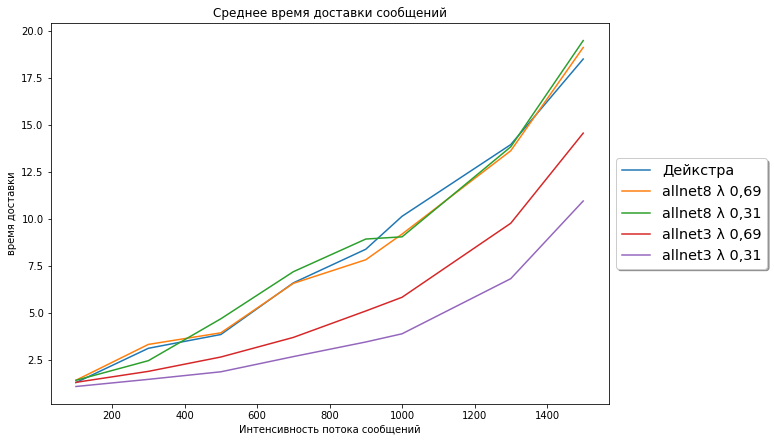

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())


Дейкстра          0.624629
allnet8 λ 0,69    0.623942
allnet8 λ 0,31    0.624733
allnet3 λ 0,69    0.621474
allnet3 λ 0,31    0.620565

Дейкстра          95.290664
allnet8 λ 0,69    94.611831
allnet8 λ 0,31    94.772893
allnet3 λ 0,69    96.712647
allnet3 λ 0,31    98.874693

Дейкстра          8.241505
allnet8 λ 0,69    8.138680
allnet8 λ 0,31    8.392194
allnet3 λ 0,69    5.612143
allnet3 λ 0,31    4.036470
